__CRASHCAL__

CrashCal is an AI-powered solution designed to automate car damage assessment by analyzing vehicle images. It detects whether a car is damaged, identifies the damaged part, estimates the severity of the damage, and predicts the repair cost. This tool aims to streamline the insurance claims and repair estimation process with speed and accuracy.

Step 1: Car Detection

Step 2: Brand Detection

Step 3: Damage Detection

Step 4: Damage Localization (Which Part is Damaged)

Step 5: Damage Severity Estimation

Step 6: Repair Cost Prediction

Step 7: Integration and Frontend Development

__STEP 1: CAR DETECTION__

1. Importing libraries 

In [31]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import UnidentifiedImageError, Image
import warnings
warnings.filterwarnings("ignore")

In [32]:
import tensorflow as tf
print(tf.__version__)

2.17.0


2. Data Cleaning
   
   a). Iterates through images in specified folders, 

   b). verifies if they are corrupted, 

   c). and removes any corrupted images it finds.

In [2]:
def remove_corrupted_images(data_dir):
    for folder in ['car', 'not_car']:
        folder_path = os.path.join(data_dir, folder)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            try:
                img = Image.open(file_path)
                img.verify()  # Check if image is corrupted
            except (IOError, UnidentifiedImageError):
                print(f"Removing corrupted image: {file_path}")
                os.remove(file_path)

# Call this function on your dataset folder
data_dir = r"E:\car_crash\cars"
remove_corrupted_images(data_dir)

This function attempts to load and preprocess an image, returning it as a normalized array, and skips the image if it’s corrupted.

In [3]:
def load_image_safe(image_path):
    try:
        img = image.load_img(image_path, target_size=(150, 150))
        return image.img_to_array(img) / 255.0
    except UnidentifiedImageError:
        print(f"Warning: Skipping corrupted image {image_path}")
        return None

Generates batches of preprocessed images and their corresponding labels for training a neural network.

In [4]:
from tensorflow.keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, img_size=(150, 150)):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return len(self.file_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_paths = self.file_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        labels = []
        
        for i, path in enumerate(batch_paths):
            img = load_image_safe(path)
            if img is not None:
                images.append(img)
                labels.append(batch_labels[i])
        
        return np.array(images), np.array(labels)

3. Data preparation pipeline.

In [5]:
from sklearn.model_selection import train_test_split

# Get image paths and labels
car_paths = [os.path.join(data_dir, 'car', img) for img in os.listdir(os.path.join(data_dir, 'car'))]
not_car_paths = [os.path.join(data_dir, 'not_car', img) for img in os.listdir(os.path.join(data_dir, 'not_car'))]

all_image_paths = car_paths + not_car_paths
labels = [1] * len(car_paths) + [0] * len(not_car_paths)  # 1 for car, 0 for not_car

# Split the data into train and validation sets
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(all_image_paths, labels, test_size=0.2, random_state=42)

# Create generators
train_generator = CustomDataGenerator(train_image_paths, train_labels, batch_size=250)
validation_generator = CustomDataGenerator(val_image_paths, val_labels, batch_size=250)

4. CNN model
   
   a) using three convolutional layers with ReLU activation & passes it through fully connected layers for binary classification with a sigmoid output. 

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

5. Model training 

   a) trains CNN model on training dataset
   
   b) tests the model on validation dataset
   
   c) runs for 5 epochs

In [7]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 387s 8s/step - accuracy: 0.6255 - loss: 0.8239 - val_accuracy: 0.9447 - val_loss: 0.1985
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 368s 7s/step - accuracy: 0.9501 - loss: 0.1882 - val_accuracy: 0.9596 - val_loss: 0.1345
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 370s 7s/step - accuracy: 0.9619 - loss: 0.1293 - val_accuracy: 0.9676 - val_loss: 0.1008
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 367s 7s/step - accuracy: 0.9660 - loss: 0.1145 - val_accuracy: 0.9665 - val_loss: 0.1109
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.9678 - loss: 0.0953 - val_accuracy: 0.9644 - val_loss: 0.1128


Model evaluation

In [8]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc:.2f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9627 - loss: 0.1218
Validation Accuracy: 0.96


6. Model saving

In [9]:
# Save the model in HDF5 format
model.save('car_classification_model.h5')

7. Data visualization

   a) plot for training vs validation accuracy and loss 

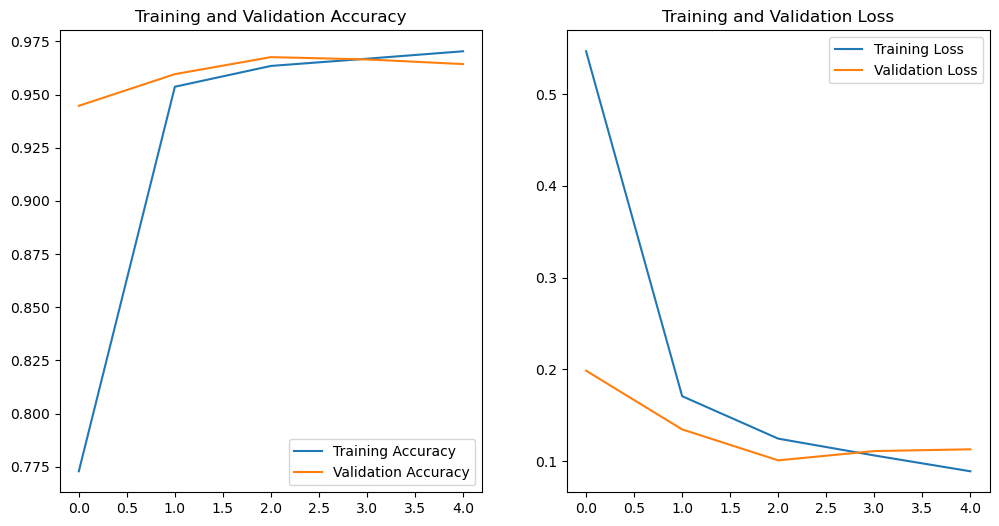

In [10]:
# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

b) Confusion Matrix 

11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step


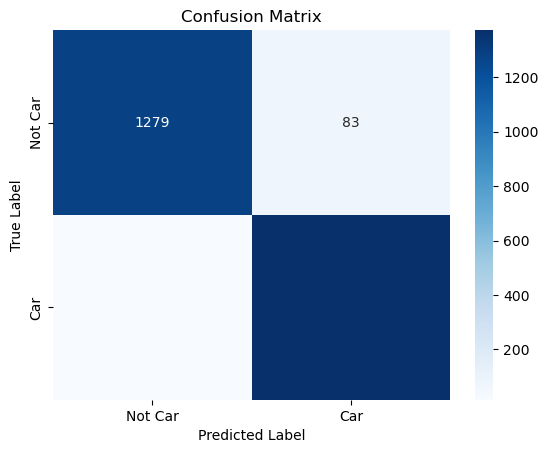

In [11]:
# Evaluate model on validation set
Y_pred = model.predict(validation_generator)
y_pred = (Y_pred > 0.5).astype(int)

cm = confusion_matrix(val_labels[:len(y_pred)], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Car', 'Car'], yticklabels=['Not Car', 'Car'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

8. Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


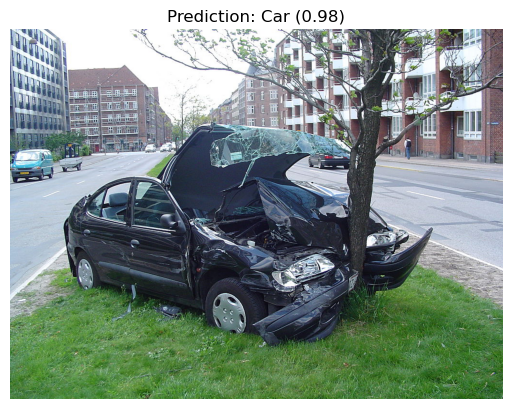

In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150))  # Resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to visualize prediction
def visualize_prediction(image_path, model):
    img_array = load_image(image_path)
    prediction = model.predict(img_array)[0][0]  # Predict using the trained model
    
    # Assign label based on prediction threshold (0.5)
    label = "Car" if prediction >= 0.5 else "Not Car"
    
    # Load original image for display
    original_image = image.load_img(image_path)
    
    # Plot the image with the predicted label
    plt.imshow(original_image)
    plt.title(f"Prediction: {label} ({prediction:.2f})")
    plt.axis('off')
    plt.show()

# Test with an example image from your dataset
test_image_path = r"E:\car_crash\test\test1.jpg"  # Path to test image
visualize_prediction(test_image_path, model)


In [13]:
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    if prediction < 0.8:
        print("The image is predicted to be: Not a Car")
    else:
        print("The image is predicted to be: A Car")

# Test with a random image
img_path = r"E:\car_crash\test\test1.jpg"  # Image path
predict_image(model, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
The image is predicted to be: A Car


__STEP 2: Brand Detection__

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [19]:
# Get the directory path from the user
base_dir = r"E:\car_crash\Brand_Dataset_Damaged"

In [20]:
# Parameters
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32
EPOCHS = 20

In [21]:
# 2. Data Preprocessing
base_dir = base_dir  # Use the sampled dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80-20 train-validation split
    horizontal_flip=True,
    zoom_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

Found 610 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


Number of samples in generator: 610
Classes: {'Ford_Mustang': 0, 'Mazda_3': 1, 'Toyota_Camry': 2}


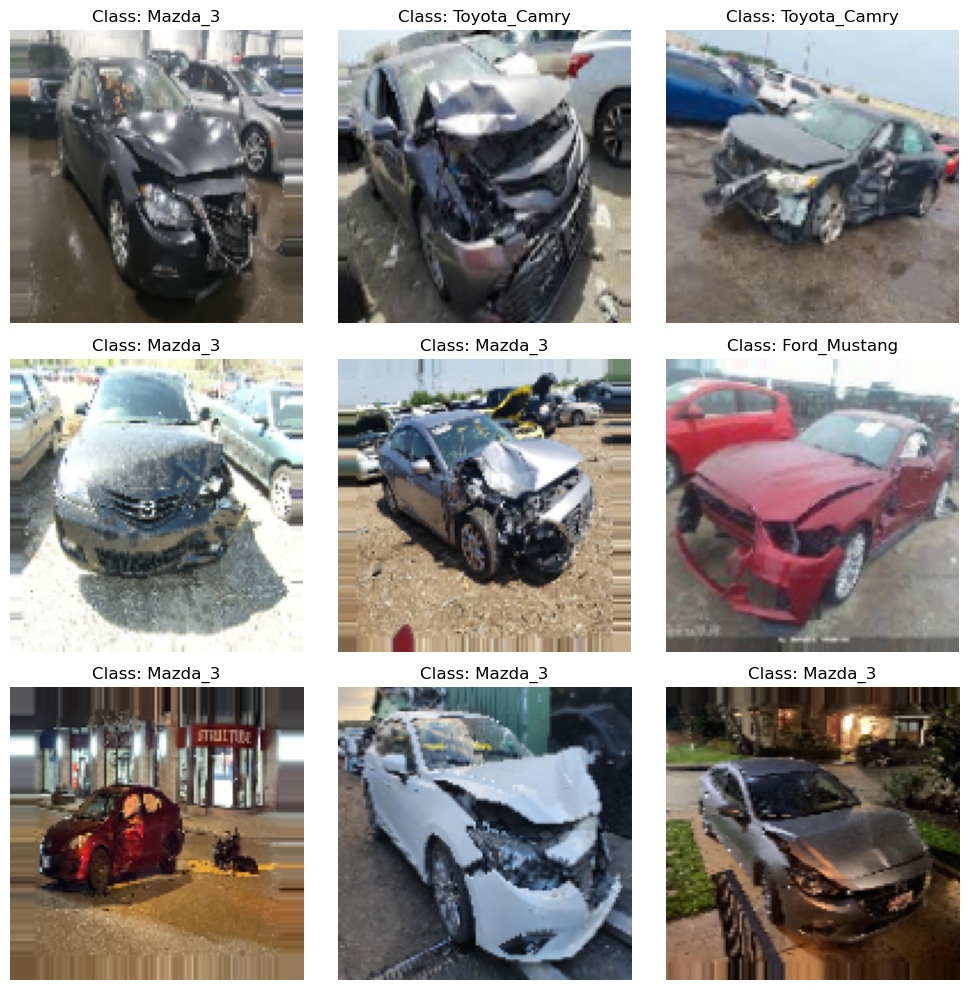

In [22]:
def visualize_data(generator):
    """
    Visualizes 9 images from the given generator.
    """
    # Check if the generator has images
    if generator.samples == 0:
        print("The generator has no samples. Please check your dataset.")
        return

    print(f"Number of samples in generator: {generator.samples}")
    print(f"Classes: {generator.class_indices}")

    # Reset the generator to start from the beginning
    generator.reset()

    # Plot images
    class_labels = list(generator.class_indices.keys())
    plt.figure(figsize=(10, 10))
    for i in range(9):
        img, label = next(generator)  # Fetch one batch of data
        plt.subplot(3, 3, i+1)
        plt.imshow(img[0])  # Display the first image in the batch
        plt.title(f"Class: {class_labels[np.argmax(label[0])]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_data(train_generator)


In [23]:
# 4. Model Building
model = Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,707 (28.20 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# 5. Training with Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 809ms/step - accuracy: 0.3418 - loss: 1.9717 - val_accuracy: 0.4133 - val_loss: 1.1916
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 716ms/step - accuracy: 0.4171 - loss: 1.0751 - val_accuracy: 0.4400 - val_loss: 1.0649
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 753ms/step - accuracy: 0.4062 - loss: 1.0698 - val_accuracy: 0.3800 - val_loss: 1.0617
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 683ms/step - accuracy: 0.4566 - loss: 1.0168 - val_accuracy: 0.4267 - val_loss: 1.0618
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 713ms/step - accuracy: 0.4923 - loss: 0.9835 - val_accuracy: 0.4333 - val_loss: 1.0959
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 767ms/step - accuracy: 0.5325 - loss: 0.9510 - val_accuracy: 0.4533 - val_loss: 1.0493
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 625ms/step - accuracy: 0.5476 - loss: 0.9544 - val_accuracy: 0.3867 - val_loss: 1.0830
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 725ms/step - accuracy: 0.5014 - loss: 0.9817 - val_accu

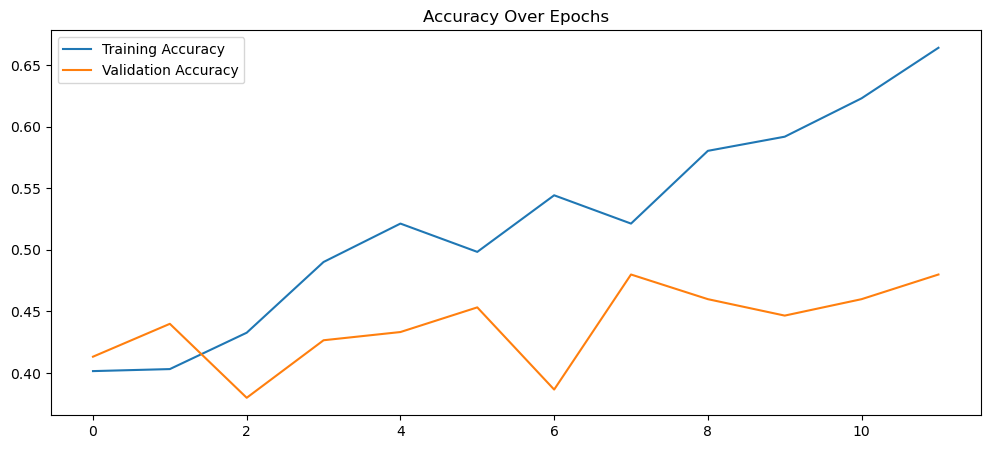

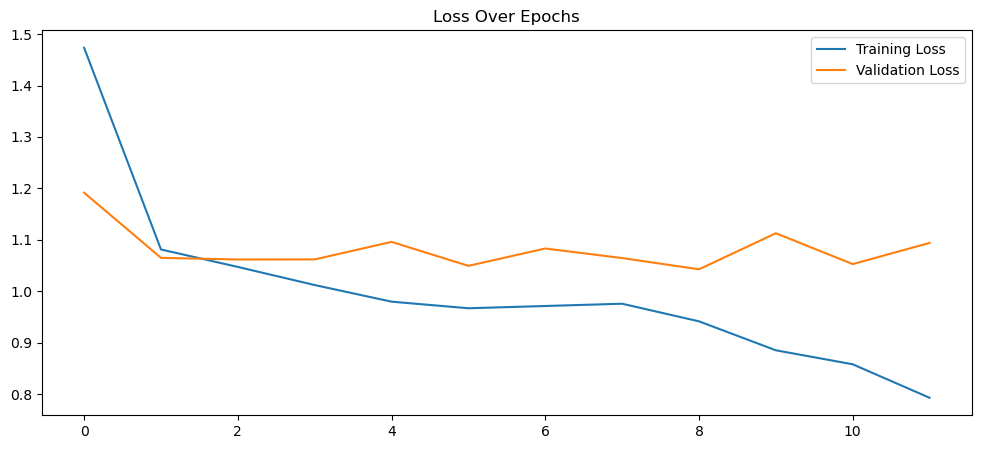

In [25]:
# 6. Plot Training History
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [26]:
# 7. Save the Model
model.save("brand_detection_model.h5")

In [27]:
# 8. Evaluate the Model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - accuracy: 0.4333 - loss: 1.0594
Validation Loss: 1.0340, Validation Accuracy: 0.4600


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


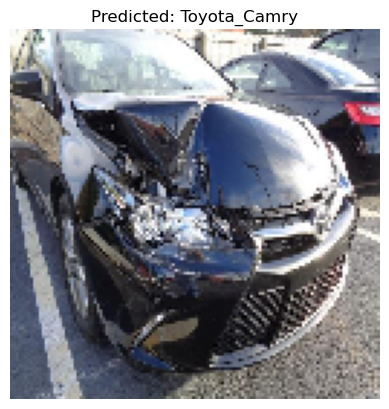

Predicted Class: Toyota_Camry


In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Assuming your model is loaded as 'model'
# Assuming 'train_generator' is your image data generator

# Extract categories (class labels) from the folder structure
categories = list(train_generator.class_indices.keys())

def predict_image_and_display(model, img_path, categories):
    # Load the image and resize it to match input size of the model
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the class of the image
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])  # Get the class with the highest probability
    predicted_class = categories[predicted_class_idx]  # Map index to category name

    # Display the image
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()

    return predicted_class

# Example of using the function
test_image_path = r"E:\car_crash\test\test7.jpg"  # Replace with your test image path
if os.path.exists(test_image_path):
    predicted_class = predict_image_and_display(model, test_image_path, categories)
    print(f"Predicted Class: {predicted_class}")
else:
    print("Test image path not found.")

__STEP 3: DAMAGE DETECTION__

1. Importing libaries 

In [30]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

2. Loading training & validation dataset 

In [31]:
# Directories
train_dir = r"E:\car_crash\damage\training"
val_dir = r"E:\car_crash\damage\validation"

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32

3. Data(image) preprocessing 

   a) creates data generators to preprocess images by rescaling pixel values , resizing them to the IMG_SIZE and assigning binary labels for classification.

   b) prepares the data for a binary classification model, handling image loading, resizing, and normalization in batches (BATCH_SIZE).

In [32]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2344 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


4. CNN model
   
   a) using three convolutional layers with ReLU activation & passes it through fully connected layers for binary classification with a sigmoid output. 

In [33]:
# CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

5. Model training 

   a) trains CNN model on training dataset
   
   b) tests the model on validation dataset
   
   c) runs for 10 epochs

In [34]:
history = model.fit(
    train_generator,validation_data=val_generator,epochs=10  # Adjust based on performance
)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 66s 806ms/step - accuracy: 0.5922 - loss: 0.6898 - val_accuracy: 0.6826 - val_loss: 0.6004
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 26s 330ms/step - accuracy: 0.7302 - loss: 0.5333 - val_accuracy: 0.7304 - val_loss: 0.5446
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 26s 338ms/step - accuracy: 0.7909 - loss: 0.4534 - val_accuracy: 0.7739 - val_loss: 0.4672
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 27s 333ms/step - accuracy: 0.8503 - loss: 0.3454 - val_accuracy: 0.6674 - val_loss: 0.8370
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 26s 335ms/step - accuracy: 0.8678 - loss: 0.2867 - val_accuracy: 0.7957 - val_loss: 0.4587
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - accuracy: 0.9094 - loss: 0.2193 - val_accuracy: 0.7783 - val_loss: 0.5263
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 27s 349ms/step - accuracy: 0.9446 - loss: 0.1478 - val_accuracy: 0.8043 - val_loss: 0.5319
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 27s 338ms/step - accuracy: 0.9826 - loss: 0.0692 - val_accu

6. Model evaluation

In [35]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.8080 - loss: 0.9387
Validation Accuracy: 0.78


7. Data visualization

   a) plot for training vs validation accuracy and loss 

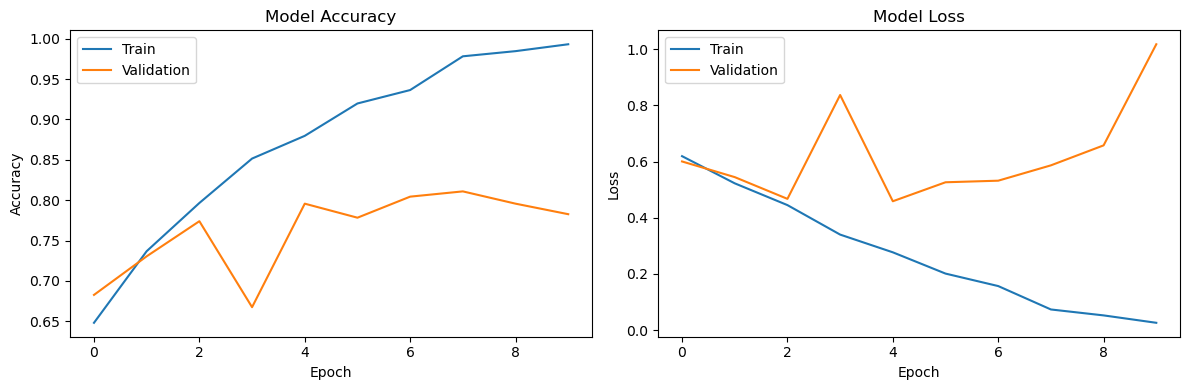

In [36]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

b) Predicted vs Actual Results on Sample Validation Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


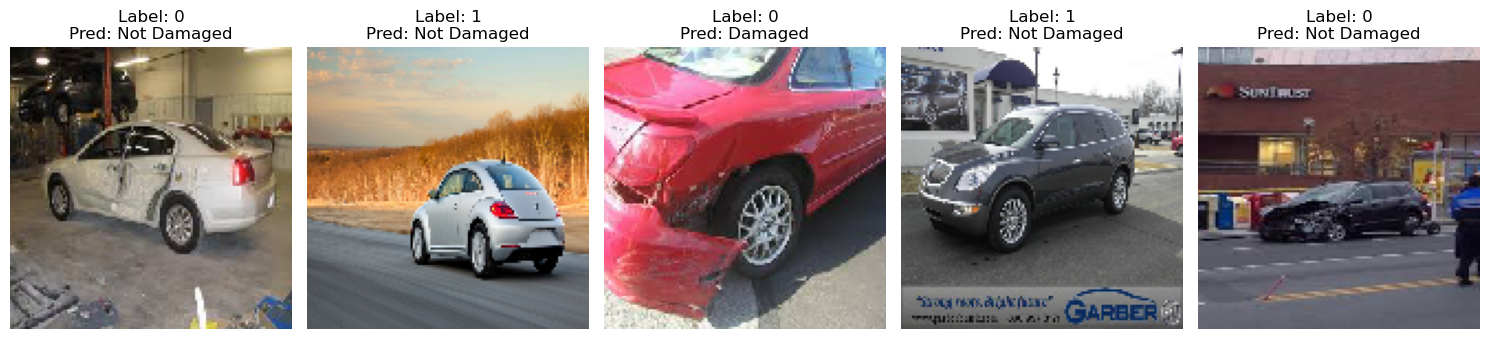

In [37]:
def visualize_predictions(generator, num_images=5):
    # Get a batch of images and labels
    images, labels = next(generator)

    # Generate predictions
    predictions = model.predict(images)

    # Plot images with predictions
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        # Show label and prediction
        plt.title(f"Label: {int(labels[i])}\nPred: {'Not Damaged' if predictions[i] > 0.4 else 'Damaged'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions on validation data
visualize_predictions(val_generator)

c) Confusion matrix 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


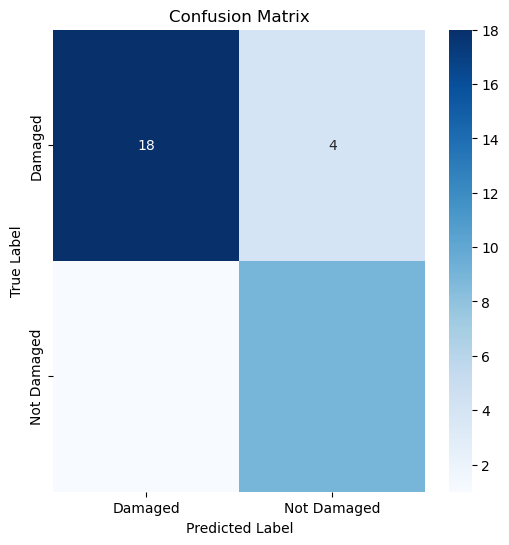

In [38]:
# Generate predictions for the entire validation set
val_images, val_labels = next(val_generator)
predictions = (model.predict(val_images) > 0.85).astype("int32")

# Create a confusion matrix
cm = confusion_matrix(val_labels, predictions)

# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Damaged', 'Not Damaged'], yticklabels=['Damaged', 'Not Damaged'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

8. Model saving 

In [39]:
model.save('damage_detection_model.h5')

9. Model loading 

In [40]:
# Load the trained model
model = load_model('damage_detection_model.h5')

10. Prediction

In [41]:
# Function to preprocess and predict on a new image
def predict_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to model input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img)
    
    # Convert prediction to human-readable form
    if prediction[0] > 0.85:
        print("Prediction: The car is not damaged.")
    else:
        print("Prediction: The car is damaged.")

# Predict on a random image
image_path = r"E:\car_crash\test\test2.jpg"
predict_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Prediction: The car is damaged.


__STEP 4: LOCATION_DETECTION__

1. Importing Libraries

In [54]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2. Loading training & validation dataset 

In [55]:
img_width, img_height = 224, 224
batch_size = 32

train_data_dir = r"E:\car_crash\position\training"
validation_data_dir = r"E:\car_crash\position\validation"

In [56]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

3. Data(image) preprocessing 

   a) creates data generators to preprocess images by rescaling pixel values , resizing them to the IMG_SIZE and assigning binary labels for classification.

   b) prepares the data for a binary classification model, handling image loading, resizing, and normalization in batches (BATCH_SIZE).

In [57]:
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3439 images belonging to 3 classes.
Found 894 images belonging to 3 classes.


4. CNN model
   
   a) using three convolutional layers with ReLU activation & passes it through fully connected layers for binary classification with a sigmoid output. 

In [58]:
# Model architecture with BatchNormalization and Dropout
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,247,363 (84.87 MB)

 Trainable params: 22,246,403 (84.86 MB)

 Non-trainable params: 960 (3.75 KB)

5. Model training 

   a) trains CNN model on training dataset
   
   b) tests the model on validation dataset
   
   c) runs for 10 epochs

In [59]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 508s 5s/step - accuracy: 0.4242 - loss: 1.6809 - val_accuracy: 0.6711 - val_loss: 0.9483 - learning_rate: 0.0010
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 434s 4s/step - accuracy: 0.4768 - loss: 1.2148 - val_accuracy: 0.4407 - val_loss: 1.1591 - learning_rate: 0.0010
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.4887 - loss: 1.1428 - val_accuracy: 0.6499 - val_loss: 0.7993 - learning_rate: 0.0010
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.5293 - loss: 1.0054 - val_accuracy: 0.5503 - val_loss: 0.9274 - learning_rate: 0.0010
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.5324 - loss: 1.0009 - val_accuracy: 0.6510 - val_loss: 0.8090 - learning_rate: 0.0010
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5514 - loss: 0.9472
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
108/108 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.5514 - loss: 0.947

6. Model evaluation

In [60]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy * 100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6353 - loss: 0.8107
Validation accuracy: 64.99%


7. Model saving

In [61]:
# Save the trained model
model.save('location_detection_model.h5')

8. Model loading

In [62]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('location_detection_model.h5')

9. Prediction

In [65]:
import warnings 
warnings.filterwarnings("ignore")

# Image dimensions
img_width, img_height = 224, 224

# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale the image
    return img_array

# Load the saved model
model = load_model("location_detection_model.h5")

# Predict damage location
img_path = r"E:\car_crash\test\test4.jpeg"  # Replace with your image path
img_array = load_and_preprocess_image(img_path)

# Get prediction
prediction = model.predict(img_array)

# Decode prediction
class_labels = ['front', 'side', 'back']
predicted_class = np.argmax(prediction, axis=1)[0]  # Get the index of the highest probability
predicted_label = class_labels[predicted_class]

print(f"The predicted damage location is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The predicted damage location is: back


10. Visualization 

a) Training and Validation Accuracy and Loss Visualization

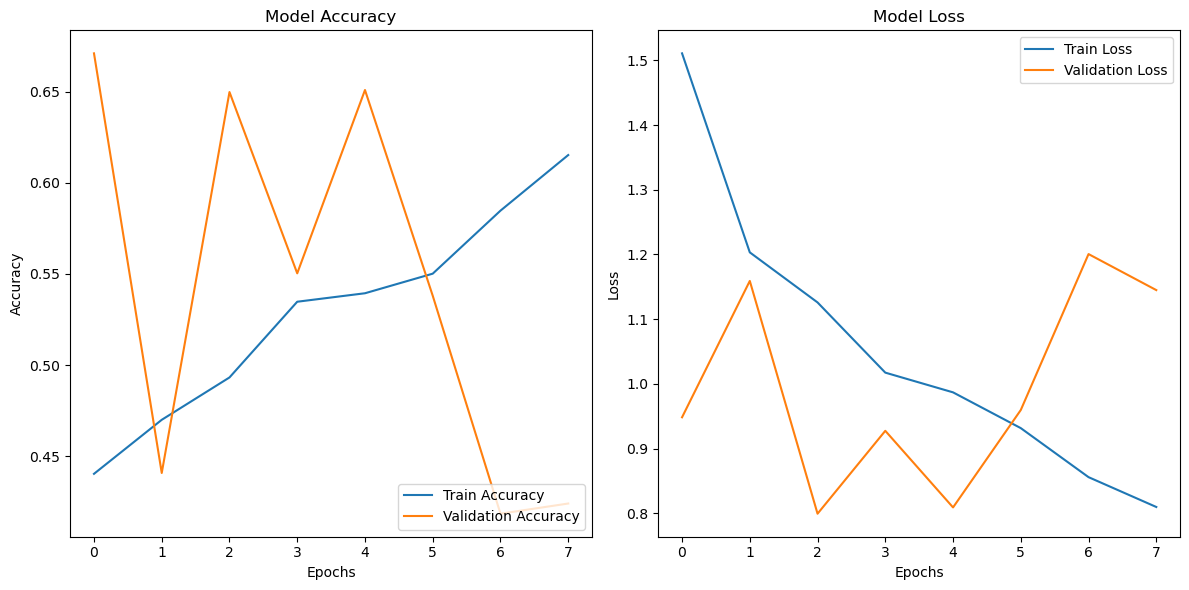

In [66]:
# Plot training and validation accuracy/loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

b) Confusion Matrix for Predictions on the Validation Set

28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 579ms/step


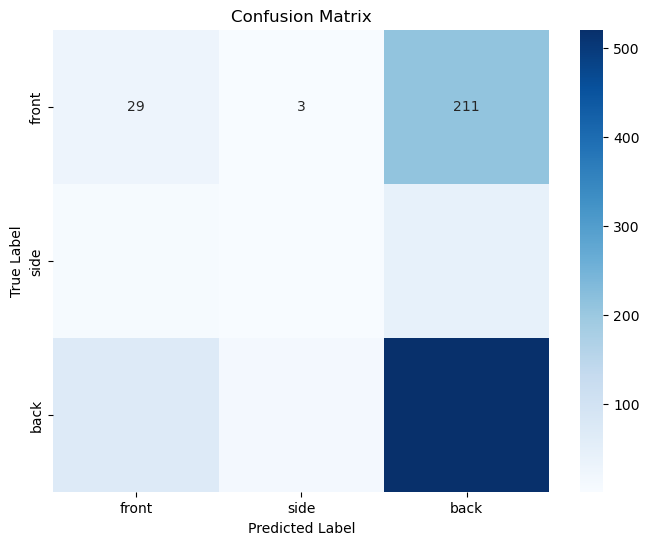

In [67]:
import warnings 
warnings.filterwarnings("ignore")

# Generate predictions on validation data
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
class_names = ['front', 'side', 'back']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

c) Visualization of Test Image and Predicted Class

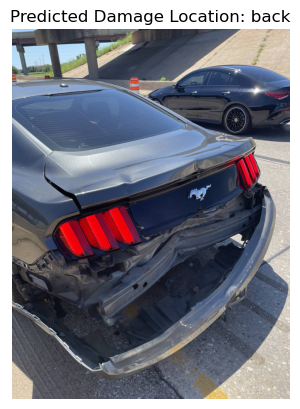

In [68]:
# Display the image with prediction
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Damage Location: {predicted_label}")
plt.show()

__Step 5: Part Detection__

 Refer to Step_5__Part_detection_model. ipynb for code 

__STEP 6: SEVERITY CHECK__

In [92]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Set up the paths
train_dir = r"E:\car_crash\level\training"  # Replace with your training directory path
val_dir = r"E:\car_crash\level\validation"   # Replace with your validation directory path

In [93]:
# Define parameters
img_height, img_width = 150, 150  # Adjust based on your needs
batch_size = 32
epochs = 10  # You can adjust this based on your dataset

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [94]:
# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [95]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 925ms/step - accuracy: 0.3700 - loss: 1.2672 - val_accuracy: 0.4062 - val_loss: 1.0849
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3438 - loss: 1.0973 - val_accuracy: 0.2727 - val_loss: 1.0655
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 468ms/step - accuracy: 0.4123 - loss: 1.0804 - val_accuracy: 0.3875 - val_loss: 1.0875
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.0600 - val_accuracy: 0.5455 - val_loss: 0.9790
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 494ms/step - accuracy: 0.3855 - loss: 1.0750 - val_accuracy: 0.4500 - val_loss: 1.0645
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 1.0839 - val_accuracy: 0.4545 - val_loss: 1.0854
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 505ms/step - accuracy: 0.4071 - loss: 1.0626 - val_accuracy: 0.4437 - val_loss: 1.0489
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 1.1350 - val_accuracy: 0.3636

In [97]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.4174 - loss: 1.0704
Validation Loss: 1.1096835136413574, Validation Accuracy: 0.4152046740055084


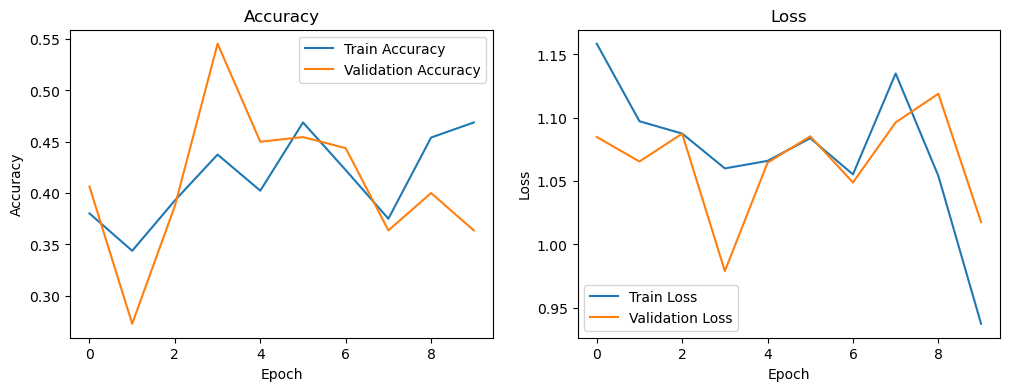

In [98]:
# Plot training & validation accuracy and loss
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

In [99]:
# Save the entire model to a file
model.save('severity_model.h5')

In [100]:
# Define category names corresponding to the class indices
category_names = ['minor', 'moderate', 'severe']  # Adjust this based on your folder names

# Function to predict category of a new image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_category = category_names[predicted_class_index]
    
    return predicted_category

# Example prediction (replace with an actual image path)
new_image_path = r"E:\car_crash\test\test3.jpg"  # Replace with your image path
predicted_category = predict_image(new_image_path)
print(f'Predicted Category: {predicted_category}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Predicted Category: severe
